In [1]:
import sys
import os

# 경로 설정: 스크립트 경로에서 상위 디렉토리로 이동한 후 src 경로 추가
health_data_path = os.path.abspath(os.path.join('..', 'src'))
health_learning_data_path = os.path.abspath(os.path.join(os.getcwd(), "../../HealthModelPipeline/dataflow/src"))
preprocessing_path = os.path.abspath(os.path.join(os.getcwd(), "../../PipelinePrep/src"))

paths = [health_data_path, health_learning_data_path, preprocessing_path]

def add_paths(paths):
    """
    지정된 경로들이 sys.path에 없으면 추가하는 함수.
    
    Parameters:
    - paths (list): 추가하려는 경로들의 리스트.
    """
    for path in paths:
        if path not in sys.path:
            sys.path.append(path)
            print(f"Path added: {path}")
        else:
            print(f"Path already exists: {path}")
            
add_paths(paths)

Path added: C:\Users\pc021\Desktop\dx_project\techross\HealthPipeline\src
Path added: C:\Users\pc021\Desktop\dx_project\techross\HealthModelPipeline\dataflow\src
Path added: C:\Users\pc021\Desktop\dx_project\techross\PipelinePrep\src


In [2]:
# basic
import pandas as pd

# time
import schedule
import time

# module.healthchecker
from stat_healthchecker.total_system_health_algorithm import apply_system_health_algorithms_with_total
from models_healthchecker.total_system_health_learning_algorithm import apply_system_health_learning_algorithms_with_total
from prep.load_processing import distribute_by_application

# module.dataline
from stat_dataline.scheduled_data_fetcher import fetch_data_on_schedule
from stat_dataline.logger_confg import logger
from stat_dataline.select_dataset import get_dataframe_from_database

In [3]:
def get_latest_date_on_schedule():
    
#     fetched_data = fetch_data_on_schedule('ecs_data')
    fetched_data = get_dataframe_from_database('ecs_dat1', 'ecs_data', all=True)
    
    grouped_data = fetched_data.groupby(['SHIP_ID','OP_INDEX','SECTION']).count() 
    
    grouped_index = grouped_data.index

    return grouped_index, fetched_data

In [4]:
# data = get_dataframe_from_database('ecs_dat1', 'ecs_data', all=True)

# grouped_data = data.groupby(['SHIP_ID','OP_INDEX','SECTION']).count() 
# grouped_index = grouped_data.index
# datas = pd.DataFrame(index = grouped_index).reset_index()

# datas[(datas['SHIP_ID']=='T20220324006') & (datas['OP_INDEX']==648) & (datas['SECTION']==0)]

In [ ]:
def schedule_health_assessment():
    
    grouped_index, fetched_data = get_latest_date_on_schedule()
    
    for index in grouped_index:
        ship_id =  'T140113-00101' # index[0]
        op_index = 939 # index[1]
        section = 0 # index[2] 
        
        # 데이터 처리를 위한 갯수 조건을 만족하는지 판단
        selected_df = fetched_data[(fetched_data['SHIP_ID']==ship_id) & (fetched_data['OP_INDEX']==op_index) & (fetched_data['SECTION']==section)]
        date_time = selected_df.iloc[0]['DATA_TIME']
        data_len = len(selected_df)
        
        print(f'SHIP_ID : {ship_id} / OP_INDEX : {op_index} / SECTION : {section} -  데이터 선택 ({data_len})')
        
        if (data_len>=160) :
            print(f'SHIP_ID : {ship_id} / OP_INDEX : {op_index} / SECTION : {section} -  조건 통과')      
            
#             sensor, preprocessed = distribute_by_application(ship_id=ship_id, op_index=op_index, section=section)
            
#             if sensor is None and preprocessed is None:
#                 print("선박 데이터 프레임이 존재하지 않습니다.")
#                 continue       

#             elif preprocessed is not None:
#                 logger.info(f'SHIP_ID={ship_id} | OP_INDEX={op_index} | SECTION={section} | START_TIME={date_time} | LOG_ENTRY=The results were derived from the model and statistics package | TYPE=all | IS_PROCESSED=True')
#                 print("전처리 후 학습 데이터 프레임이 존재합니다.")
#                 apply_system_health_algorithms_with_total(sensor, ship_id, op_index, section)
#                 apply_system_health_learning_algorithms_with_total(data=preprocessed, ship_id=ship_id, op_index=op_index, section=section)
#             else:
#                 logger.info(f'SHIP_ID={ship_id} | OP_INDEX={op_index} | SECTION={section} | START_TIME={date_time}  | LOG_ENTRY=After preprocessing, the model data frame does not exist, so only the statistical algorithm proceeds alone | TYPE=stats | IS_PROCESSED=True')
#                 print("전처리 후 모델 데이터 프레임이 존재하지 않아 통계 알고리즘 단독 진행합니다.")
#                 apply_system_health_algorithms_with_total(data=sensor, ship_id=ship_id, op_index=op_index, section=section)
               
            try:
                sensor, preprocessed = distribute_by_application(ship_id=ship_id, op_index=op_index, section=section)
                if sensor is None and preprocessed is None:
                    print("선박 데이터 프레임이 존재하지 않습니다.")
                    continue       

                elif preprocessed is not None:
                    logger.info(f'SHIP_ID={ship_id} | OP_INDEX={op_index} | SECTION={section} | START_TIME={date_time} | LOG_ENTRY=The results were derived from the model and statistics package | TYPE=all | IS_PROCESSED=True')
                    print("전처리 후 학습 데이터 프레임이 존재합니다.")
                    apply_system_health_algorithms_with_total(sensor, ship_id, op_index, section)
                    apply_system_health_learning_algorithms_with_total(data=preprocessed, ship_id=ship_id, op_index=op_index, section=section)
                else:
                    logger.info(f'SHIP_ID={ship_id} | OP_INDEX={op_index} | SECTION={section} | START_TIME={date_time}  | LOG_ENTRY=After preprocessing, the model data frame does not exist, so only the statistical algorithm proceeds alone | TYPE=stats | IS_PROCESSED=True')
                    print("전처리 후 모델 데이터 프레임이 존재하지 않아 통계 알고리즘 단독 진행합니다.")
                    apply_system_health_algorithms_with_total(data=sensor, ship_id=ship_id, op_index=op_index, section=section)
                
#             except ValueError as e :
#                 logger.info(f'SHIP_ID={ship_id} | OP_INDEX={op_index} | SECTION={section} | START_TIME={date_time} | LOG_ENTRY={e} | TYPE=exceptional_handling | IS_PROCESSED=False')
#                 print(f'에러 발생: {e}. 다음 반복으로 넘어갑니다.')
#                 continue  # 에러 발생 시 다음 반복으로 넘어감\

#             except KeyError as e :
#                 logger.info(f'SHIP_ID={ship_id} | OP_INDEX={op_index} | SECTION={section} | START_TIME={date_time} | LOG_ENTRY={e} | TYPE=exceptional_handling | IS_PROCESSED=False')
#                 print(f'에러 발생: {e}. 다음 반복으로 넘어갑니다.')

#             except TypeError as e :
#                 logger.info(f'SHIP_ID={ship_id} | OP_INDEX={op_index} | SECTION={section} | START_TIME={date_time} | LOG_ENTRY={e} | TYPE=exceptional_handling | IS_PROCESSED=False')
#                 print(f'에러 발생: {e}. 다음 반복으로 넘어갑니다.')
#                 continue  # 에러 발생 시 다음 반복으로 넘어감
                
            except IndexError as e :
                print(f'에러 발생: {e}. 다음 반복으로 넘어갑니다.')
                logger.info(f'SHIP_ID={ship_id} | OP_INDEX={op_index} | SECTION={section} | START_TIME={date_time} | LOG_ENTRY={e} | TYPE=exceptional_handling | IS_PROCESSED=False')
                continue  # 에러 발생 시 다음 반복으로 넘어감 
        else:
            logger.info(f'SHIP_ID={ship_id} | OP_INDEX={op_index} | SECTION={section} | START_TIME={date_time} | LOG_ENTRY=The data length is {data_len} and does not satisfy the condition | TYPE=data_length_limit | IS_PROCESSED=False')

SHIP_ID : T140113-00101 / OP_INDEX : 939 / SECTION : 0 -  데이터 선택 (344)
SHIP_ID : T140113-00101 / OP_INDEX : 939 / SECTION : 0 -  조건 통과
distribute_by_application 함수 실행 시간: 0.6367초
전처리 후 학습 데이터 프레임이 존재합니다.
Loaded data type: <class 'pycaret.internal.pipeline.Pipeline'>
apply_system_health_algorithms_with_total 함수 실행 시간: 0.5580초
모델이 C:\Users\pc021\Desktop\dx_project\techross\HealthModelPipeline\dataflow\src\models_model\csu_model에서 성공적으로 불러와졌습니다.
DataFrame has been successfully loaded into tc_ai_csu_system_health_group_v0.0.0 table in ecs_test database.
Database connection closed.
DataFrame has been successfully loaded into tc_ai_csu_model_system_health_group_v0.0.0 table in ecs_test database.
Database connection closed.
모델이 C:\Users\pc021\Desktop\dx_project\techross\HealthModelPipeline\dataflow\src\models_model\sts_model에서 성공적으로 불러와졌습니다.
DataFrame has been successfully loaded into tc_ai_sts_system_health_group_v0.0.0 table in ecs_test database.
Database connection closed.
DataFrame has be

ValueError: `distance` must be greater or equal to 1

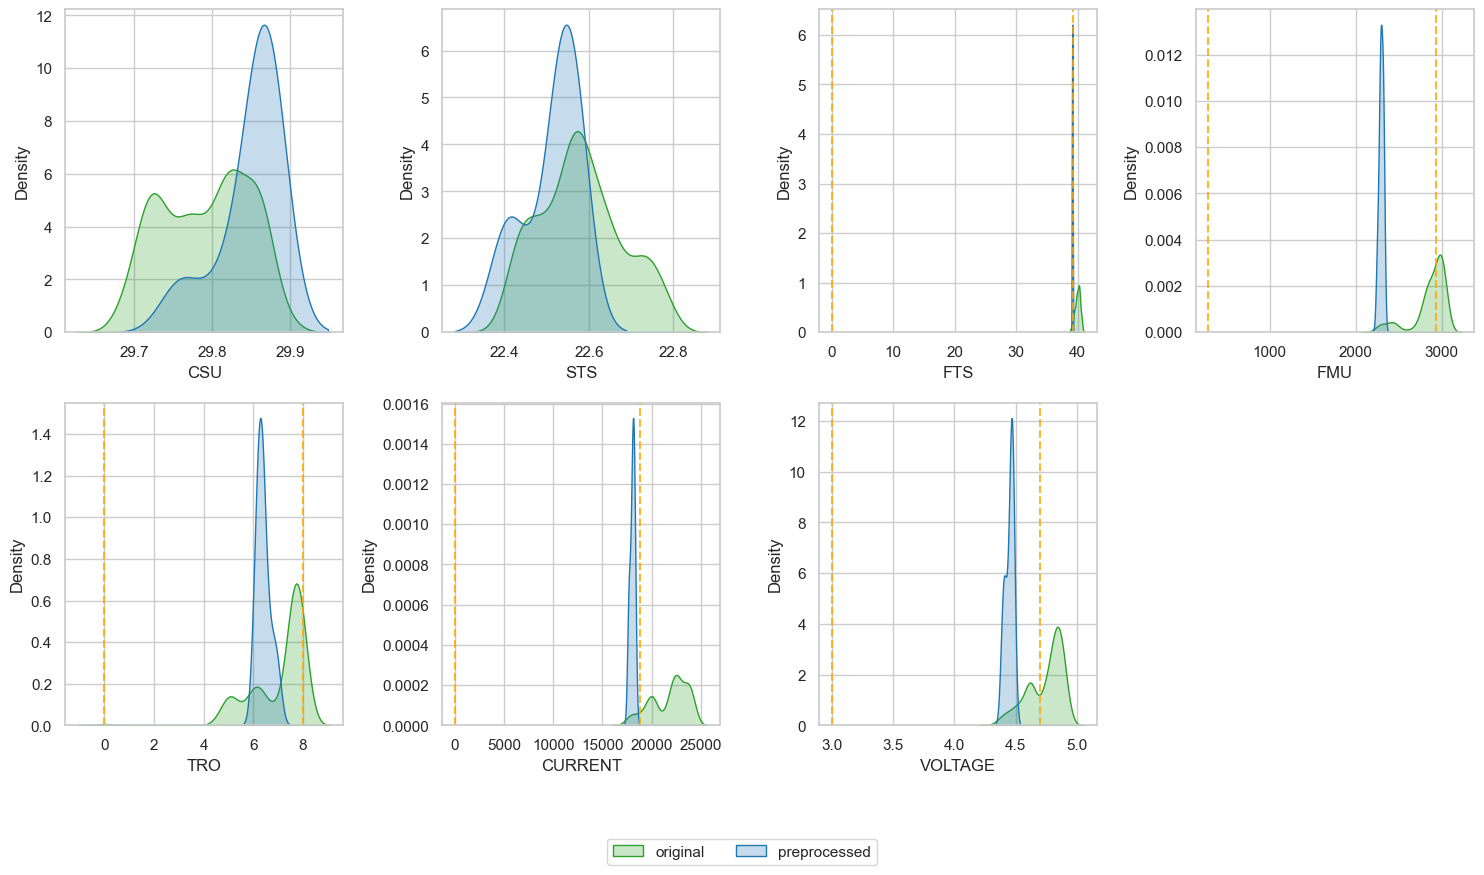

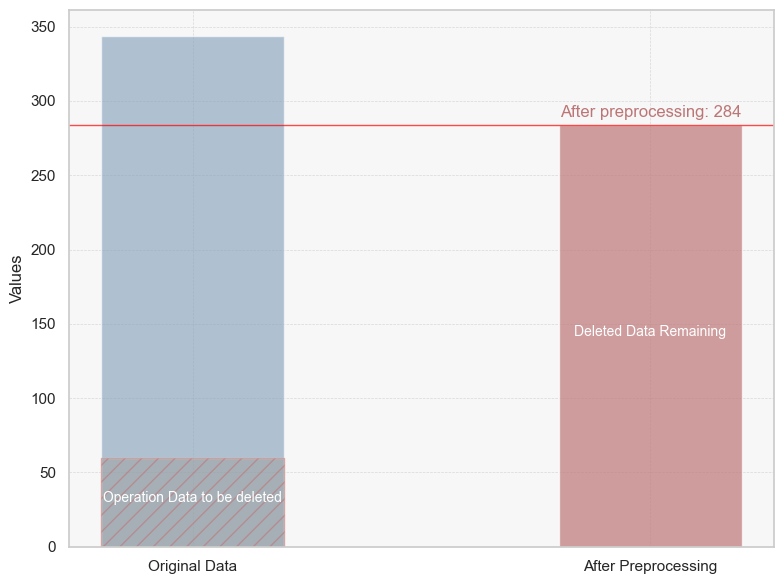

In [11]:
schedule_health_assessment() 

In [ ]:
# # 스케줄 설정: 3일에 한 번씩 데이터 가져오기
# #schedule.every(3).days.at("14:00").do(schedule_health_assessment)
# schedule.every(5).minutes.do(schedule_health_assessment)

# # 스케줄 지속 실행
# while True:
#     print("스케줄 시작")

#     schedule.run_pending()
#     time.sleep(1)